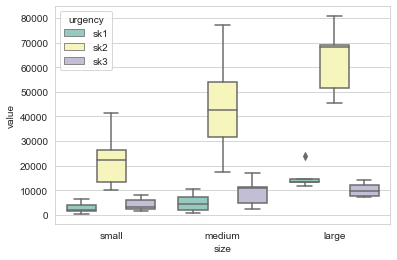

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/dgina23_hospital_sizes.csv')
d = df[['size', 'sk1', 'sk2', 'sk3']]

# reshape the d dataframe suitable for statsmodels package
d_melt = pd.melt(d, id_vars=['size'], value_vars=['sk1', 'sk2', 'sk3'])
d_melt = d_melt.dropna(subset=['value'])
d_melt.columns = ['size', 'urgency', 'value']

sns.boxplot(x="size", y="value", hue="urgency", data=d_melt, palette="Set3");

In [61]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('value ~ C(size) + C(urgency) + C(size):C(urgency)', data=d_melt).fit()

# Choosing typ=3 because of unbalanced data
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,1.193018e+09,1.0,13.552930,4.988477e-04
C(size),5.477618e+08,2.0,3.111343,5.180049e-02
C(urgency),8.480050e+09,2.0,48.167552,3.333054e-13
C(size):C(urgency),2.288335e+09,4.0,6.498989,2.056713e-04
Residual,5.281595e+09,60.0,NaN,NaN


In [62]:
from bioinfokit.analys import stat

res = stat()
res.anova_stat(df=d_melt, res_var='value', anova_model='value~C(size)+C(urgency)+C(size):C(urgency)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(size),2.0,3.709315e+09,1.854658e+09,21.069290,1.171772e-07
C(urgency),2.0,1.685671e+10,8.428353e+09,95.747816,2.131200e-19
C(size):C(urgency),4.0,2.288335e+09,5.720838e+08,6.498989,2.056713e-04
Residual,60.0,5.281595e+09,8.802659e+07,NaN,NaN


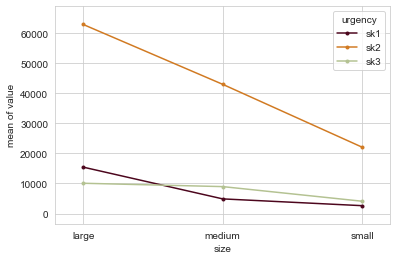

In [63]:
from statsmodels.graphics.factorplots import interaction_plot

# Generate interaction plot
fig = interaction_plot(x=d_melt['size'], trace=d_melt['urgency'], response=d_melt['value'], colors=['#4c061d','#d17a22', '#b4c292'])

plt.show()

In [64]:
def red_font_negatives(series):
    highlight = 'font-weight: bold; color: red;'
    default = ''
    return [highlight if e <= 0.001 else default for e in series]

# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res.tukey_hsd(df=d_melt, res_var='value', xfac_var=['size','urgency'], anova_model='value ~ C(size) + C(urgency) + C(size):C(urgency)')
res.tukey_summary.head()

t1 = res.tukey_summary.style \
    .format(precision=5, thousands="", decimal=",") \
    .hide(axis='index') \
    .apply(red_font_negatives, axis=0, subset=['p-value'])

t1

/Users/nplhse/opt/anaconda3/lib/python3.9/site-packages/bioinfokit/analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


group1,group2,Diff,Lower,Upper,q-value,p-value
"('small', 'sk1')","('small', 'sk2')","19477,50000","4384,07966","34570,92034","5,87180","0,00319"
"('small', 'sk1')","('small', 'sk3')","1478,87500","-13614,54534","16572,29534","0,44583","0,90000"
"('small', 'sk1')","('medium', 'sk1')","2262,35000","-12056,52579","16581,22579","0,71891","0,90000"
"('small', 'sk1')","('medium', 'sk2')","40433,15000","26114,27421","54752,02579","12,84856","0,00100"
"('small', 'sk1')","('medium', 'sk3')","6354,85000","-7964,02579","20673,72579","2,01940","0,87716"
"('small', 'sk1')","('large', 'sk1')","12840,05000","-4369,09695","30049,19695","3,39495","0,30283"
"('small', 'sk1')","('large', 'sk2')","60380,05000","43170,90305","77589,19695","15,96467","0,00100"
"('small', 'sk1')","('large', 'sk3')","7472,85000","-9736,29695","24681,99695","1,97584","0,89515"
"('small', 'sk2')","('small', 'sk3')","17998,62500","2905,20466","33092,04534","5,42597","0,00860"
"('small', 'sk2')","('medium', 'sk1')","17215,15000","2896,27421","31534,02579","5,47051","0,00781"


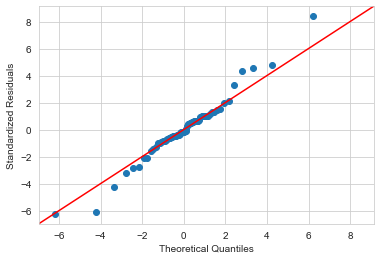

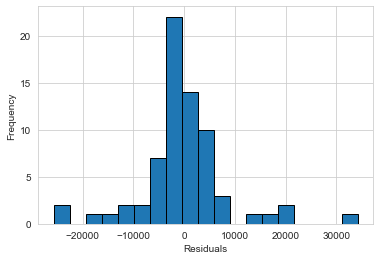

In [65]:
import scipy.stats as stats

# Test ANOVA assumptions
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, stats.t, fit=True, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [66]:
import scipy.stats as stats

# Shapiro-Wilk to check the normal distribution of residuals
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.8912215232849121 2.011440483329352e-05


In [67]:
# Bartlett’s test to check the Homogeneity of variances
res.bartlett(df=d_melt, res_var='value', xfac_var='urgency')
res.bartlett_summary

,Parameter,Value
0,Test statistics (T),59.2029
1,Degrees of freedom (Df),2.0000
2,p value,0.0000


In [68]:
# Levene’s test
res = stat()
res.levene(df=d_melt, res_var='value', xfac_var='urgency')
res.levene_summary

,Parameter,Value
0,Test statistics (W),27.0774
1,Degrees of freedom (Df),2.0000
2,p value,0.0000
